In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltools.data import Brain_Data, Design_Matrix
from nltools.file_reader import onsets_to_dm
from nltools.plotting import plotBrain, plotTBrain
import os, glob
import numpy as np
import seaborn as sns
import pandas as pd

# How to run preprocessing with nipype 
_Written by Jin Hyun Cheong_


Nipype is a python package that allows you to call preprocessing tools from multiple imaging softwares including SPM, FSL, ANTS, Freesurfer and others. 

The process involves specifying how you want to run each step and connecting the inputs and outputs of each step.

Lets examine how the preprocessing script is organized. 
Please read the comments in the scripts for explanation. 


In [ ]:
# This is the Nipype preprocessing pipeline which will be called for each subject. 
# It takes 4 inputs which are the base_dir path, output_dir path, the subjec_id, and the path to spm files. 
def Preproc_Pipeline(base_dir=None, output_dir=None, subject_id=None, spm_path=None):
    """ Create a preprocessing workflow using nipype
    Args:
        base_dir: path to data folder where raw subject folder is located
        output_dir: path to where key output files should be saved
        subject_id: subject_id (str)
        spm_path: path to spm folder
    Returns:
        workflow: a nipype workflow that can be run
    """

    import nipype.interfaces.io as nio
    import nipype.interfaces.utility as util
    from nipype.interfaces.utility import Merge as Merge_List
    from nipype.pipeline.engine import Node, Workflow
    from nipype.interfaces.fsl.maths import UnaryMaths
    from nipype.interfaces.nipy.preprocess import Trim
    from nipype.algorithms.rapidart import ArtifactDetect
    from nipype.interfaces import spm
    from nipype.interfaces.spm import Normalize12
    from nipype.algorithms.misc import Gunzip
    from nipype.interfaces.nipy.preprocess import ComputeMask
    import nipype.interfaces.matlab as mlab
    from cosanlab_preproc.utils import get_resource_path, get_vox_dims, get_n_volumes
    from cosanlab_preproc.interfaces import Plot_Coregistration_Montage, Plot_Realignment_Parameters, Create_Covariates, Plot_Quality_Control
    import os
    import glob

    ########################################
    ## Setup Paths and Nodes
    ########################################

    # Specify Paths
    canonical_file = os.path.join(spm_path,'canonical','single_subj_T1.nii')
    template_file = os.path.join(spm_path,'tpm','TPM.nii')

    # Set the way matlab should be called
    mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")
    mlab.MatlabCommand.set_default_paths(spm_path)

    # Get File Names for different types of scans.  Parse into separate processing streams
    datasource = Node(interface=nio.DataGrabber(infields=['subject_id'], outfields=[
                'struct', 'func']),name='datasource')
    datasource.inputs.base_directory = base_dir
    datasource.inputs.template = '*'
    datasource.inputs.field_template = {'struct':'%s/*T1*.nii',
                                        'func':'%s/*run*.nii.gz'}
    datasource.inputs.template_args = {'struct':[['subject_id']],
                                       'func':[['subject_id']]}
    datasource.inputs.subject_id = subject_id
    datasource.inputs.sort_filelist=True

    # iterate over functional scans to define paths
    func_source = Node(interface=util.IdentityInterface(fields=['scan']),name="func_source")
    func_source.iterables = ('scan', glob.glob(os.path.join(base_dir,subject_id,'*run*nii.gz')))


    ########################################
    ## Preprocessing
    ########################################

    # Trim - remove first few TRs if a buffer was inserted  
    n_vols = 0 # number of volumes to be trimemd. 
    trim = Node(interface = Trim(), name='trim')
    trim.inputs.begin_index=n_vols

    #Realignment - 6 parameters - realign to either the mean image or the first image. 
    realign = Node(interface=spm.Realign(), name="realign")
    realign.inputs.register_to_mean = True

    #Coregister - 12 parameters - register functional data to structural data
    coregister = Node(interface=spm.Coregister(), name="coregister")
    coregister.inputs.jobtype = 'estwrite'

    #Plot Realignment - Plot result of realignment. 
    plot_realign = Node(interface=Plot_Realignment_Parameters(), name="plot_realign")

    #Artifact Detection
    art = Node(interface=ArtifactDetect(), name="art")
    art.inputs.use_differences      = [True,False]
    art.inputs.use_norm             = True
    art.inputs.norm_threshold       = 1
    art.inputs.zintensity_threshold = 3
    art.inputs.mask_type            = 'file'
    art.inputs.parameter_source     = 'SPM'

    # Gunzip - unzip the functional and structural images
    gunzip_struc = Node(Gunzip(), name="gunzip_struc")
    gunzip_func = Node(Gunzip(), name="gunzip_func")

    # Normalize - normalizes functional and structural images to the MNI template
    normalize = Node(interface=Normalize12(jobtype='estwrite',tpm=template_file),
                     name="normalize")

    #Plot normalization Check
    plot_normalization_check = Node(interface=Plot_Coregistration_Montage(), name="plot_normalization_check")
    plot_normalization_check.inputs.canonical_img = canonical_file

    #Plot QA
    plot_qa = Node(Plot_Quality_Control(),name="plot_qa")

    #Create Mask
    compute_mask = Node(interface=ComputeMask(), name="compute_mask")
    #remove lower 5% of histogram of mean image
    compute_mask.inputs.m = .05

    #Smooth
    #implicit masking (.im) = 0, dtype = 0
    smooth = Node(interface=spm.Smooth(), name = "smooth")
    smooth.inputs.fwhm=6

    #Create Covariate matrix
    make_cov = Node(interface=Create_Covariates(), name="make_cov")

    #Plot Quality Control Check
    quality_control = Node(interface=Plot_Quality_Control(), name='quality_control')

    # Create a datasink to clean up output files
    datasink = Node(interface=nio.DataSink(), name='datasink')
    datasink.inputs.base_directory = output_dir
    datasink.inputs.container = subject_id

    ########################################
    # Create Workflow
    ########################################

    workflow = Workflow(name = 'Preprocessed')
    workflow.base_dir = os.path.join(base_dir,subject_id)
    workflow.connect([
                        (func_source, trim,[('scan','in_file')]),
                        (trim, gunzip_func,[('out_file','in_file')]),
                        (gunzip_func, realign, [('out_file', 'in_files')]),
                        (realign, quality_control, [('realigned_files', 'dat_img')]),
                        (datasource,coregister,[('struct','source')]),
                        (coregister, normalize,[('coregistered_source','image_to_align')]),
                        (realign,coregister, [('mean_image', 'target'),
                                              ('realigned_files', 'apply_to_files')]),
                        (realign,normalize, [(('mean_image', get_vox_dims), 'write_voxel_sizes')]),
                        (coregister,normalize, [('coregistered_files', 'apply_to_files')]),
                        (normalize, smooth, [('normalized_files', 'in_files')]),
                        (realign, compute_mask, [('mean_image','mean_volume')]),
                        (compute_mask,art,[('brain_mask','mask_file')]),
                        (realign,art,[('realignment_parameters','realignment_parameters'),
                                      ('realigned_files','realigned_files')]),
                        (realign,plot_realign, [('realignment_parameters', 'realignment_parameters')]),
                        (normalize, plot_normalization_check, [('normalized_files', 'wra_img')]),
                        (realign, make_cov, [('realignment_parameters', 'realignment_parameters')]),
                        (art, make_cov, [('outlier_files', 'spike_id')]),
                        (normalize, datasink, [('normalized_files', 'structural.@normalize')]),
                        (coregister, datasink, [('coregistered_source', 'structural.@struct')]),
                        (smooth, datasink, [('smoothed_files', 'functional.@smooth')]),
                        (plot_realign, datasink, [('plot', 'functional.@plot_realign')]),
                        (plot_normalization_check, datasink, [('plot', 'functional.@plot_normalization')]),
                        (make_cov, datasink, [('covariates', 'functional.@covariates')]),
                        (quality_control, datasink, [('plot', 'functional.@quality_control')])
                     ])
    return workflow

In [ ]:
# You would call the nipype pipeline on the subject to have it preprocessed.
import os
subject_id = 'A000150'
base_dir = os.path.join('/Path/to/base/dir/')
output_dir = os.path.join('/Path/to/output/dir/')
spm_path = os.path.join('/path/to/spm/')
wf = Preproc_Pipeline(base_dir=base_dir,output_dir=output_dir,subject_id=subject_id,spm_path=spm_path)
wf.run()

Examine the quality check plots that should be in the Output directory you specified. 

In [2]:
from IPython.display import IFrame

In [4]:
# Examine the preprocessing pipeline
IFrame("http://jinhyuncheong.com/assets/fMRI/samp_graph.dot.png", width=1000, height=400)

In [13]:
# Examine Normalization results
IFrame("http://jinhyuncheong.com/assets/fMRI/samp_Normalized_Functional_Check.pdf", width=600, height=400)

In [14]:
# Examine Realignment results
IFrame("http://jinhyuncheong.com/assets/fMRI/samp_Realignment_parameters.pdf", width=600, height=400)

In [15]:
# Examine Quality Control results
IFrame("http://jinhyuncheong.com/assets/fMRI/samp_Quality_Control_Plot.pdf", width=600, height=400)

# Analysis: How to conduct a GLM analysis on 1 subject
Conducting a GLM for a single subject is easy using the Brain_Data class from nltools.   
We start with loading a subject's imaging file (*.nii.gz) with Brain Data and save it as data. 


In [8]:
# Set up base directory
base_dir = os.path.join('/Users/jinhyuncheong/Dropbox/tvstudy/Data/fMRI/Cleaned_Episode_Runs/')

filelist = np.sort(glob.glob(os.path.join(base_dir,'*ep01*.nii.gz')))
# Load the Brain data for 1 subject
data = Brain_Data(filelist[0])

To run a GLM, you need to specify your variables of interest.  
In this example we have identified onsets from the show when there are "social" scenes
and onsets when there are "place" scenes.   
These are organized in a .csv file with 3 columns Onset, Duration, and Stim.   
These column names must be the exact names for the onsets_to_dm to properly parse the onset file to a design matrix.   
The code below loads the design matrix while specifying the TR length and the length of the imaging file. 

The design matrix is then convolved with a HRF function and saved to the X attribute of our Brain_Data class.


In [9]:
## Running the GLM 
# path to design matrix file, in this case face v scenes
dm_file = os.path.join('/Users/jinhyuncheong/Dropbox/tvstudy/Data/Annotations/ep01_social_place.csv')
## Load and prepare design matrix 
# calculate run length
runLength = data.shape()[0]
dm = onsets_to_dm(dm_file, TR = 2.0, runLength = runLength,addIntercept=True)
dm = Design_Matrix(dm,sampling_rate=2.0)
# convolve the design matrix with the HRF function. 
dm_c = dm.convolve()

In [ ]:
# Load the design matrix into the X attribute of our Brain_Data object
data.X = dm_c

We can quickly observe what our design matrix (regressors) look like. 

Note the difference between the original design matrix and the convolved design matrix. 

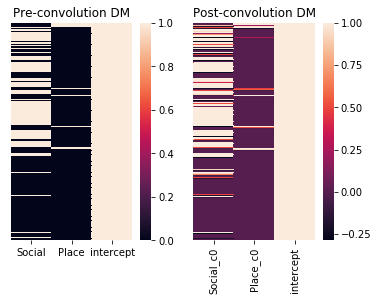

In [13]:
# Examine the design matrix. That
f,axes = plt.subplots(1,2)
_=sns.heatmap(dm,yticklabels=False,ax = axes[0],vmax=1)
_=sns.heatmap(dm_c,yticklabels=False,ax = axes[1],vmax=1)
axes[0].set_title('Pre-convolution DM')
axes[1].set_title('Post-convolution DM')

To estimate the model we call the regress() method on our data. 

This will estimate betas for each regressor in our design matrix (i.e., social, place, and intercept).

We will save the result in the variable stat.

In [5]:
# Run the GLM and save results to stat. This will save two betas one for faces, one for scenes. 
stat = data.regress()

We could examine the beta weights using stat['beta'] but to know whether the betas are significant, we need to inspect the t-stats for each voxel. 

We can plot the t-stats from the stat variable by using stat['t']. From this map we see that the STS, often related to social processes are significantly activated. 

Plotting voxels with stat value >= 2


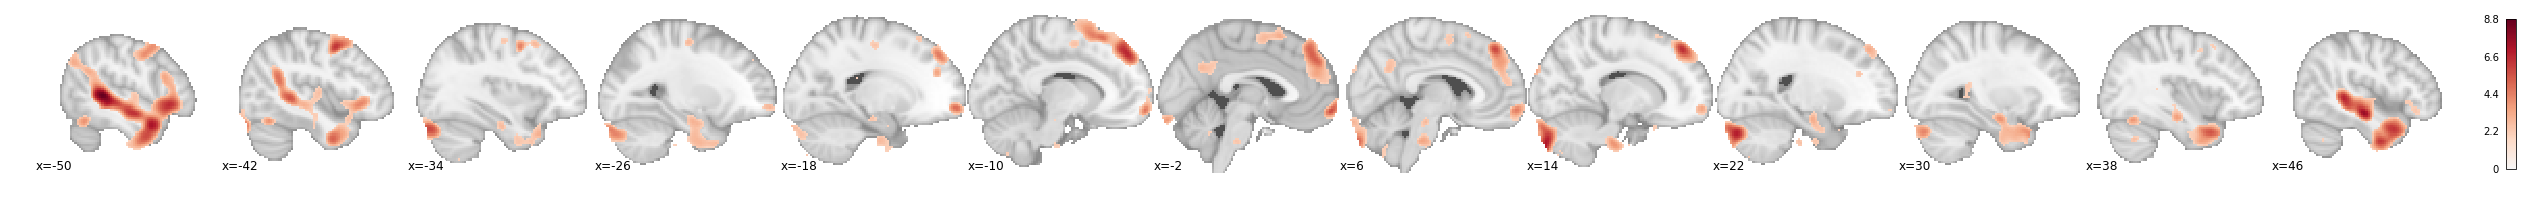

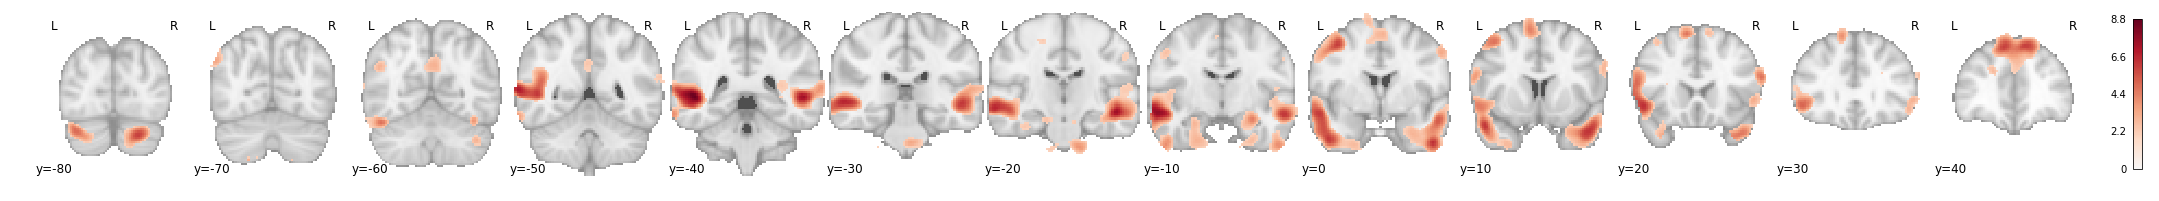

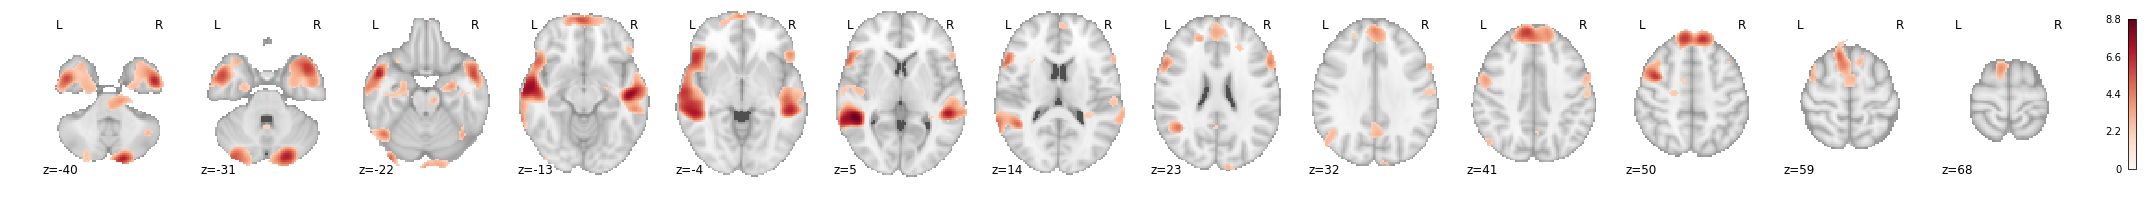

In [11]:
# plot stat map for Social scenes, notice STS
plotBrain(stat['t'][0],thr=2,how = 'mni')

We can also plot stat map for places where we see strong place area activation. 

Plotting voxels with stat value >= 2


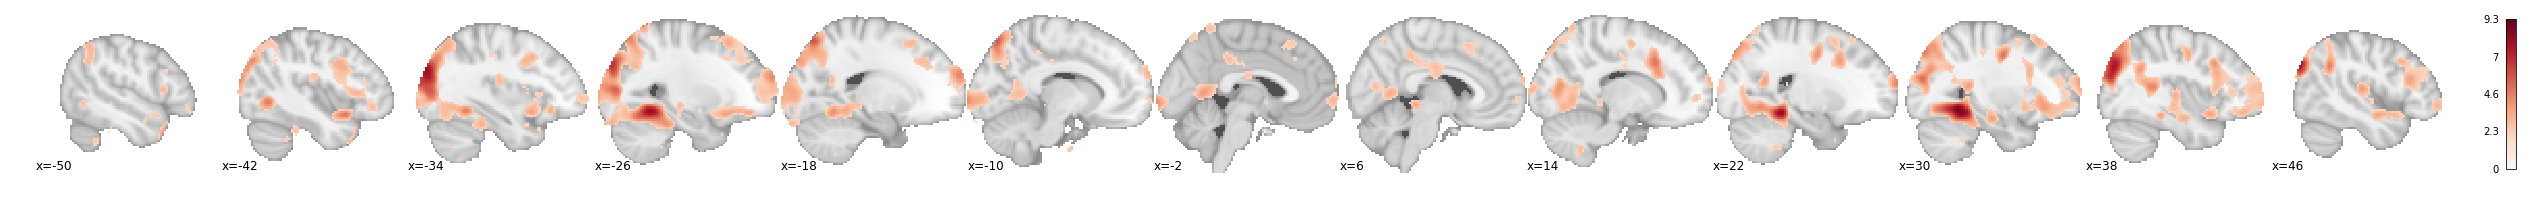

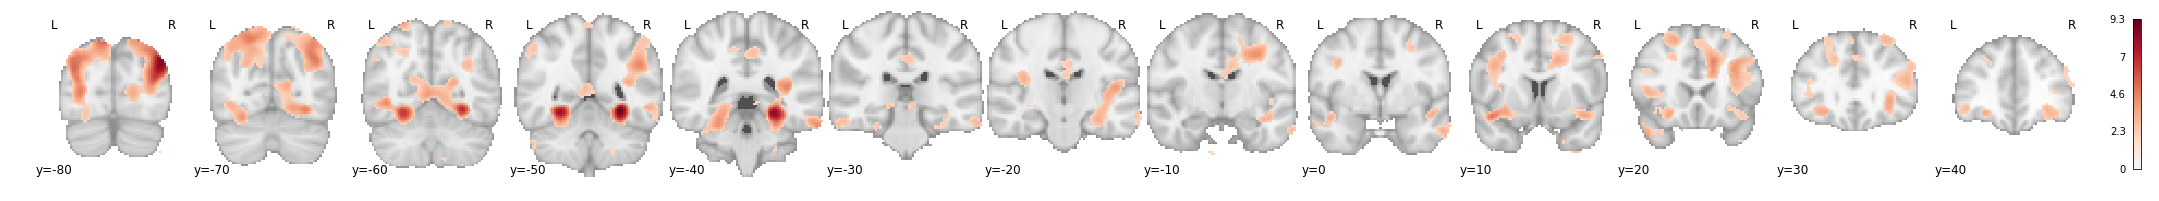

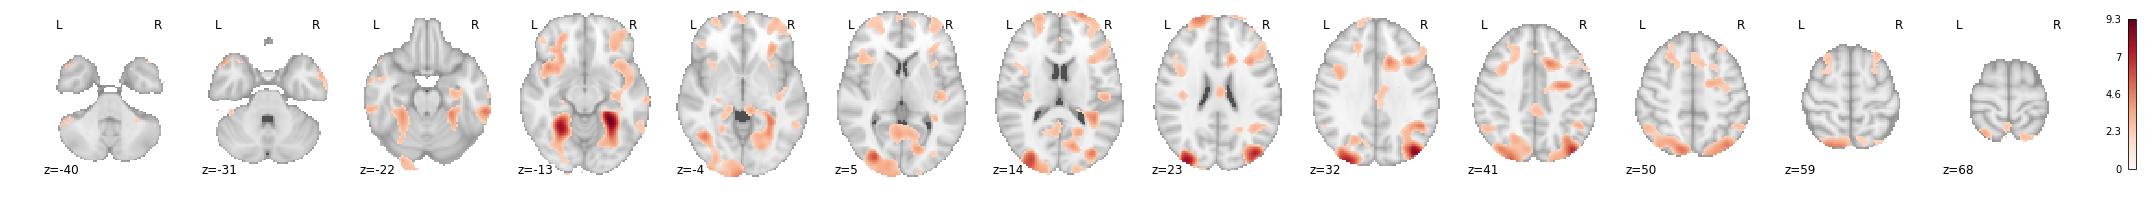

In [12]:
# plot stat map for Place scenes, notice parahippocampal place area z=-13
plotBrain(stat['t'][1],thr=2,how = 'mni')

# Run GLM for every subjects
Now we can use a for loop that will estimate the betas for each subject to perform a group analysis. 

This loop will run the design matrix we defined above and save the beta weights for each subject to the variable 'all_subjects'


In [ ]:
all_subjects = Brain_Data()
filelist = np.sort(glob.glob(os.path.join(base_dir,'*ep01*.nii.gz')))
for f in filelist: 
    print(f), # print which file currently being processed
    # Load each subject's brain data
    data = Brain_Data(f)
    # Load the convolved DM already processed. 
    data.X = dm_c 
    # Run the GLM and save results to stat. This will save two betas one for faces, one for scenes. 
    stat = data.regress()
    # save each tmap to all subjects 
    all_subjects.X = pd.DataFrame()
    all_subjects = all_subjects.append(stat['beta'])

In [11]:
all_subjects.X = pd.DataFrame()
all_subjects_face = Brain_Data()
for ix, i in enumerate([1,0,0]*13):
    if i:
        all_subjects_face=all_subjects_face.append(all_subjects[ix])
all_subjects_scene = Brain_Data()
for ix, i in enumerate([0,1,0]*13):
    if i:
        all_subjects_scene=all_subjects_scene.append(all_subjects[ix])

1-sample t-test corrected at q < 0.001 


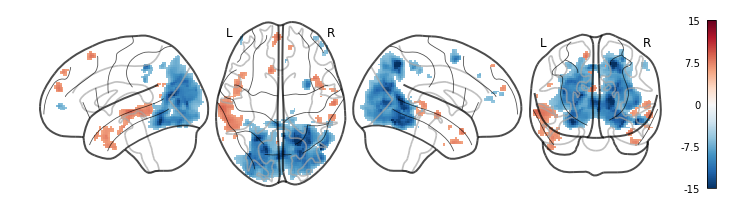

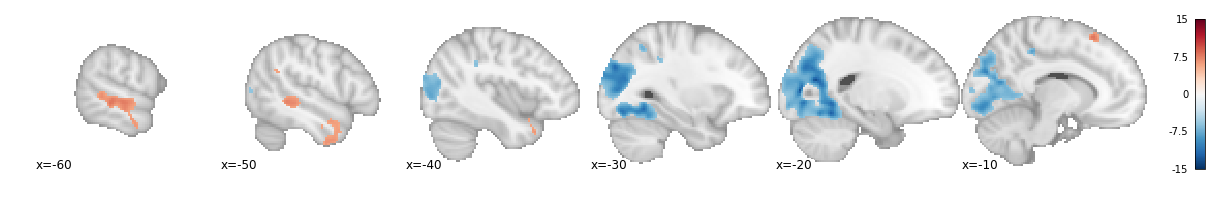

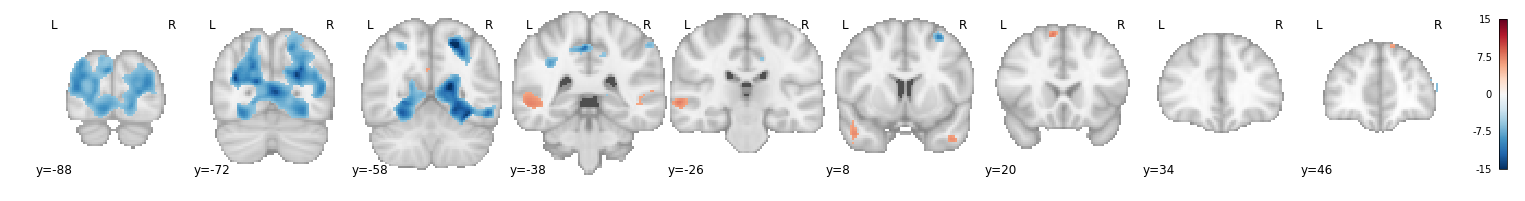

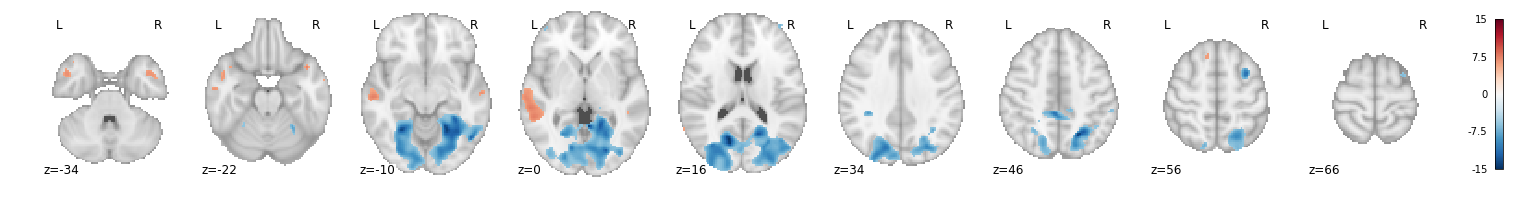

In [30]:
# Plot FDR corrected group map for Social scenes.
stat = all_subjects_face.ttest(threshold_dict={'fdr':0.001})
plotTBrain(all_subjects_face,thr='fdr',alpha=0.001,vmax = 15,
          cut_coords = [range(-60,0,10),[-88,-72,-58,-38,-26,8,20,34,46],[-34,-22,-10,0,16,34,46,56,66]])

1-sample t-test corrected at q < 0.001 


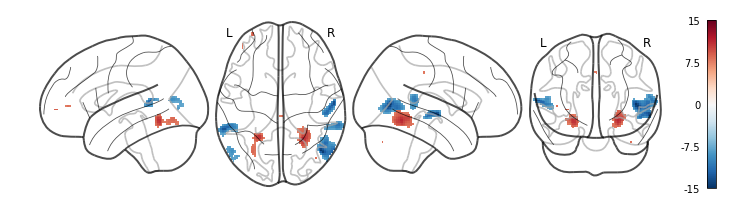

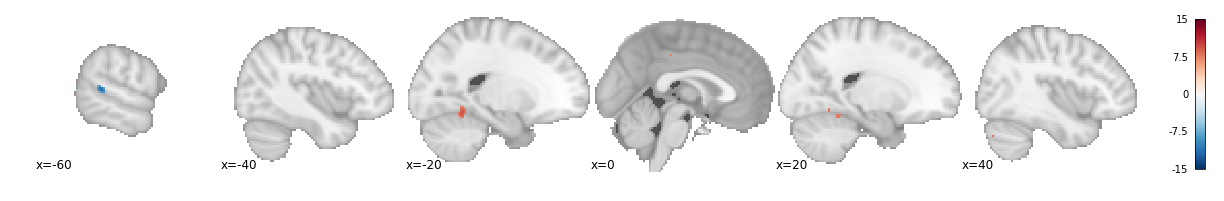

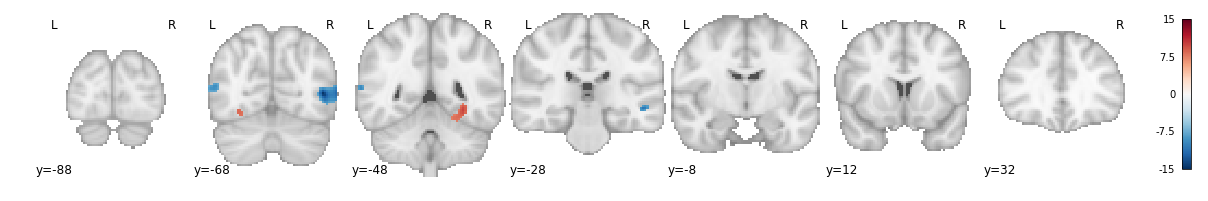

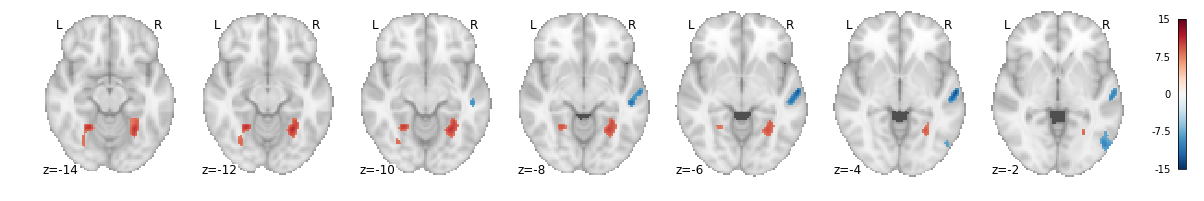

In [29]:
# Very clear hippocampal place area. 
stat = all_subjects_scene.ttest(threshold_dict={'fdr':0.001})
plotTBrain(all_subjects_scene,thr='fdr',alpha=0.001,vmax = 15,
           cut_coords = [range(-60,60,20),range(-88,46,20),range(-14,0,2)])